# Practice: Dealing with texts using CNN
_Reference: Based on YSDA [materials](https://github.com/yandexdataschool/nlp_course/blob/master/week02_classification/seminar.ipynb). Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the core assignment idea._

Today we're gonna apply the newly learned tools for the task of predicting job salary.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

## About the challenge
For starters, let's download and unpack the data.

You can also get it from [Yandex.Disk](https://yadi.sk/d/vVEOWPFY3NruT7) or [the competition page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [1]:
!curl -L "https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=1" -o Train_rev1.csv.tar.gz
!tar xzf Train_rev1.csv.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   128    0   128    0     0    241      0 --:--:-- --:--:-- --:--:--   241
100   342  100   342    0     0    400      0 --:--:-- --:--:-- --:--:--   400
100  119M  100  119M    0     0  30.4M      0  0:00:03  0:00:03 --:--:-- 65.4M


In [137]:
import time
import matplotlib.pyplot as plt
plt.style.use("dark_background")
import numpy as np

import pandas as pd
from sklearn.metrics import r2_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler

In [2]:



data = pd.read_csv("Train_rev1.csv", index_col=None)
data.shape

(244768, 12)

One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

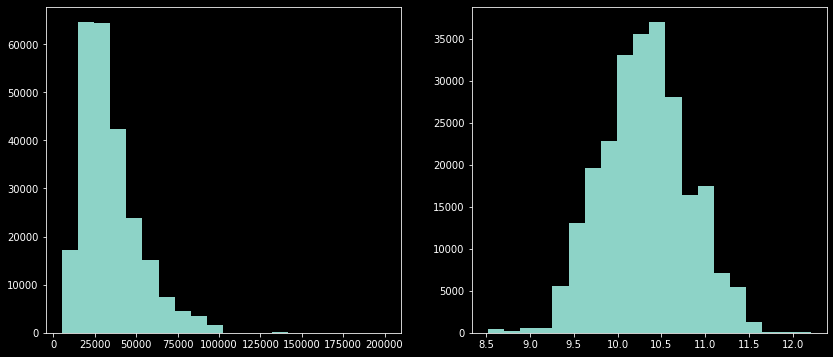

In [3]:



data["Log1pSalary"] = np.log1p(data["SalaryNormalized"]).astype("float32")

plt.figure(figsize=[14, 6])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20)

plt.subplot(1, 2, 2)
plt.hist(data["Log1pSalary"], bins=20)

plt.show()

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [5]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna("NaN")
data[text_columns] = data[text_columns].fillna("NaN")

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
223362,72400371,"Service Advisor, Morecambe, Motor Trade Job",Experienced Automotive Service Advisor require...,UK Morecambe,Morecambe,NaN,permanent,Perfect Placement UK Ltd,Logistics & Warehouse Jobs,17000 - 21000 per annum,19000,careers4a.com,9.852247
124134,69967014,Maintenance Administrator / Engineering / Redd...,Maintenance Administrator Engineering Redditch...,"Redditch, Hereford Worcestershire",UK,NaN,contract,Jenrick Engineering,Engineering Jobs,10 - 12/hour,21120,cv-library.co.uk,9.958023
219394,72340585,HR Administrator,"General HR admin to include: Starters, leavers...",London,London,NaN,contract,LRL Recruitment,HR & Recruitment Jobs,"11 - 13/hour eqiv 25,000 p/a",23040,cv-library.co.uk,10.045031


## Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [6]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [7]:
from nltk.tokenize import WordPunctTokenizer


tokenizer = WordPunctTokenizer()

# YOUR CODE HERE
# Lowercase and tokenize titles and descriptions (text_columns).
# Store items as space-separated strings of tokens.
def normalize(text):  # noqa: E302
    tokens = tokenizer.tokenize(str(text).lower())
    return " ".join(tokens)


data[text_columns] = data[text_columns].applymap(normalize)

In [8]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == "mathematical modeller / simulation analyst / opera"
assert data["Title"][54321] == "international digital account manager ( german )"

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [10]:
from collections import Counter


# YOUR CODE HERE
# Count how many times does each token occur in both "Title" and "FullDescription".
# Build a dictionary { token -> count }.
# Hint: you may or may not want to use collections.Counter
token_counts = Counter()

for row in data[text_columns].values.flatten():
    token_counts.update(row.split())

In [11]:
print("Total unique tokens :", len(token_counts))
print("\n".join(map(str, token_counts.most_common(n=5))))
print("...")
print("\n".join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print("Correct!")

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Let's see how many words are there for each count.

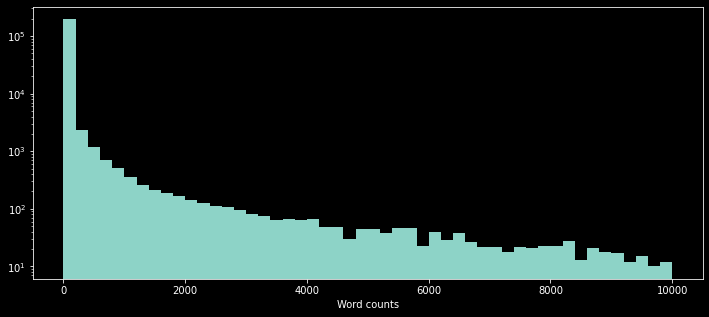

In [12]:
plt.figure(figsize=(12, 5))
plt.hist(list(token_counts.values()), range=[0, 10 ** 4], bins=50, log=True)
plt.xlabel("Word counts")
plt.show()

Now we will filter tokens a list of all tokens that occur at least 10 times.

In [11]:
list(token_counts.items())[:3]

[('engineering', 68563), ('systems', 77071), ('analyst', 34427)]

In [13]:
min_count = 10

# YOUR CODE HERE
# We shall only consider tokens that had at least min_count occurences.
# Create a list of such tokens.
tokens = [token for token, count in token_counts.items() if count > min_count]

In [14]:
# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))

assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert "me" in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 32456
Correct!


Build an inverse token index: a dictionary from token to it's index in `tokens`.

In [15]:
# YOUR CODE HERE
token_to_idx = {token: idx for idx, token in enumerate(tokens)}

In [16]:
assert isinstance(token_to_idx, dict)
assert len(token_to_idx) == len(tokens)
for tok in tokens:
    assert tokens[token_to_idx[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [17]:
UNK_IDX = token_to_idx[UNK]
PAD_IDX = token_to_idx[PAD]


def as_matrix(sequences, max_len=None):
    """Convert a list of tokens into a matrix with padding"""
    if isinstance(sequences[0], str):
        sequences = [seq.split(" ") for seq in sequences]

    sequences_max_len = max(len(seq) for seq in sequences)
    if max_len is None:
        max_len = sequences_max_len
    else:
        max_len = min(sequences_max_len, max_len)

    matrix = np.full((len(sequences), max_len), PAD_IDX)
    for i, seq in enumerate(sequences):
        for j, token in enumerate(seq):
            if j >= max_len:
                break

            matrix[i, j] = token_to_idx.get(token, UNK_IDX)

    return matrix

In [19]:
print("Lines:")
print("\n".join(data["Title"][::100000].values), end="\n\n")
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10273 28655  2055     1     1]
 [14296  2700     1     1     1]
 [26272  9698    14 14484 10270]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [20]:
from sklearn.feature_extraction import DictVectorizer


# We only consider top-1k most frequent companies to minimize memory usage
company_counts = Counter(data["Company"])
top_companies = set(name for name, count in company_counts.most_common(1000))
data["Company"] = data["Company"].apply(
    lambda company: company if company in top_companies else "Other"
)

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1));

## The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [21]:
from sklearn.model_selection import train_test_split


data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [22]:
def make_batch(data, max_len=None, word_dropout=0):
    """
    Creates a neural-network-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IDX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch["Categorical"] = categorical_vectorizer.transform(
        data[categorical_columns].apply(dict, axis=1)
    )

    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1.0 - word_dropout)

    if target_column in data.columns:
        batch[target_column] = data[target_column].values

    return batch


def apply_word_dropout(matrix, keep_prob, replace_with=UNK_IDX):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prob, 1 - keep_prob])
    dropout_mask &= matrix != PAD_IDX
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [23]:
example_batch = make_batch(data_train[:3], max_len=10)
print("Example batch:")
print(example_batch)
print("FullDescription shape:", example_batch["FullDescription"].shape)

Example batch:
{'Title': array([[26272, 28401, 31999,     1,     1,     1,     1],
       [27772,   187, 18227, 19056, 14801, 22008,  3848],
       [10082, 28895, 16876,    31,  8281, 27695,    61]]), 'FullDescription': array([[26272, 28401, 31999, 31307,   909, 26272, 28401, 31999, 15662,
        31307],
       [27772,   187, 18227, 19056, 14801, 22008,  3848, 24230,   836,
           77],
       [29212, 20872, 19591,  6092, 15662,  7773, 26125,   909, 28895,
        16876]]), 'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'Log1pSalary': array([ 9.71154 , 10.463132, 10.71444 ], dtype=float32)}
FullDescription shape: (3, 10)


In [24]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """iterates minibatches of data in random order"""
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target

        if not cycle:
            break

To generate minibatches we will use simple pyton generator.

In [25]:
data_train.head(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
0,69173058,senior support worker,senior support worker wanted a senior support ...,"Taunton, Somerset Somerset South West",Taunton,NaN,permanent,Other,Healthcare & Nursing Jobs,15931 - 17082 per annum,16506,totaljobs.com,9.711540
1,72450873,statistical / mathematical modeller in pharmac...,statistical / mathematical modeller in pharmac...,North West,North West London,NaN,permanent,Other,Scientific & QA Jobs,"From 30,000 to 40,000 per annum 30-40K",35000,totaljobs.com,10.463132
2,68364211,emc team leader ( def stan ),the opportunity my client is currently seeking...,Surrey,Surrey,NaN,permanent,Other,Engineering Jobs,45k + Bonus + Pension,45000,justengineers.net,10.714440


In [26]:
iterator = iterate_minibatches(data_train, 3)
batch, target = next(iterator)
batch["Title"].shape

(3, 3)

## Architecture

Our main model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

<img src="https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png" width=600px>

This clearly doesn't fit into PyTorch __Sequential__ interface. To build such a network, one will have to use [__PyTorch nn.Module API__](https://pytorch.org/docs/stable/nn.html#torch.nn.Module).

But to start with let's build the simple model using only the part of the data. Let's create the baseline solution using only the description part (so it should definetely fit into the Sequential model).

In [27]:
import torch.nn as nn


# Initially, our FullDescription has a shape [batch_size, seq_len].
# After an Embedding layer shape will be [batch_size, seq_len, embedding_size].
# However, Conv1d layer expects batches of shape [batch_size, embedding_size, seq_len].
# We will use this layer to fix this misunderstanding.
class Reorder(nn.Module):
    def forward(self, input):
        return input.permute((0, 2, 1))

In [29]:
emb_size = 128
out_channels = 256
simple_model = nn.Sequential(
    # YOUR CODE HERE
    nn.Embedding(len(tokens), emb_size),
    Reorder(),
    nn.Conv1d(emb_size, out_channels, 3),
    nn.BatchNorm1d(out_channels),
    nn.ReLU(),
    nn.Conv1d(out_channels, out_channels, 3),
    nn.BatchNorm1d(out_channels),
    nn.ReLU(),
    nn.AdaptiveMaxPool1d(1),
    nn.Flatten(),
    nn.Linear(out_channels, 1)
)

In [30]:
import torch

In [28]:
# 1)nn.Embedding()
ex_batch = torch.from_numpy(batch["FullDescription"]) # (batch_size, length)
print(f"ex_batch.shape: {ex_batch.shape}")
emb_layer = nn.Embedding(len(tokens), emb_size)
emb_out = emb_layer(ex_batch)
print(f"emb_out.shape: {emb_out.shape}")

ex_batch.shape: torch.Size([3, 315])

emb_out.shape: torch.Size([3, 315, 128])


In [29]:
# 2) nn.Conv1d
conv1_layer = nn.Conv1d(emb_size, out_channels, 3)
conv1_inp = emb_out.permute(0, 2, 1) # (batch_size, emb_dim, length)
conv1_out = conv1_layer(conv1_inp)  # (batch_size, out_channels, new_length_1)
print(f"conv1_inp.shape: {conv1_inp.shape}")
print(f"conv1_out.shape: {conv1_out.shape}")

conv1_inp.shape: torch.Size([3, 128, 315])

conv1_out.shape: torch.Size([3, 256, 313])


In [30]:
# 3) nn.Conv1d
conv2_layer = nn.Conv1d(out_channels, out_channels, 3)
conv2_inp = conv1_out               # (batch_size, out_channels, new_length_1)
conv2_out = conv2_layer(conv2_inp)  # (batch_size, out_channels, new_length_2)
print(f"conv2_inp.shape: {conv2_inp.shape}")
print(f"conv2_out.shape: {conv2_out.shape}")

conv2_inp.shape: torch.Size([3, 256, 313])

conv2_out.shape: torch.Size([3, 256, 311])


In [31]:
# 4)AdaptiveMaxPool1d(1)

adapt_layer = nn.AdaptiveMaxPool1d(1)
adapt_layer_inp = conv2_out  # (batch_size, out_channels, new_length_2)
adapt_layer_out = adapt_layer(adapt_layer_inp)
print(f"adapt_layer_inp.shape: {adapt_layer_inp.shape}")
print(f"adapt_layer_out.shape: {adapt_layer_out.shape}")
print(f"adapt_layer_out_flatten.shape: {nn.Flatten()(adapt_layer_out).shape}")

adapt_layer_inp.shape: torch.Size([3, 256, 311])

adapt_layer_out.shape: torch.Size([3, 256, 1])

adapt_layer_out_flatten.shape: torch.Size([3, 256])


__Remember!__ We are working with regression problem and predicting only one number.

In [31]:
import torch


# Check your model. `torch.long` tensors are required for nn.Embedding layers.
out = simple_model(torch.tensor(batch["FullDescription"], dtype=torch.long))
out

tensor([[-1.6609],
        [-1.2431],
        [-1.7229]], grad_fn=<AddmmBackward0>)

In [32]:
nn.MSELoss()(out.flatten(), torch.from_numpy(target))

tensor(140.7802, grad_fn=<MseLossBackward0>)

In [34]:
torch.rand((3, 5, 6)).flatten().shape

torch.Size([90])

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
simple_model.to(device);

And now simple training pipeline:

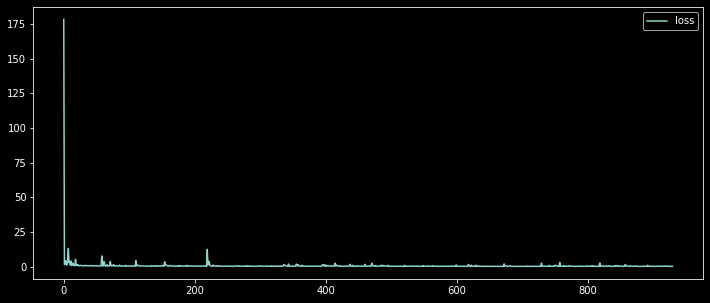

KeyboardInterrupt: 

In [34]:
from IPython.display import clear_output


epochs = 3
model = simple_model
opt = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

history = []
for epoch in range(epochs):
    for batch, target in iterate_minibatches(data_train):
        # Preprocessing the batch data and target
        batch = torch.tensor(batch["FullDescription"], dtype=torch.long, device=device)
        target = torch.tensor(target, device=device)

        predictions = model(batch)
        predictions = predictions.flatten()

        # YOUR CODE HERE
        # Compute loss.
        loss = criterion(predictions, target)
        # YOUR CODE HERE
        # Train with backprop.
        loss.backward()
        opt.step()
        opt.zero_grad()
        history.append(loss.item())
        if len(history) % 10 == 0:
            clear_output(wait=True)
            plt.figure(figsize = (12, 5))
            plt.plot(history, label="loss")
            plt.legend()
            plt.show()

To evaluate the model we can switch it to `eval` state. Let's check the model quality.

In [43]:
with torch.no_grad():
    for batch, target in iterate_minibatches(data_val):
        batch = torch.tensor(batch["FullDescription"], dtype=torch.long, device=device)
        pred = model(batch)[:, 0].cpu().numpy()
        break
    

In [64]:
@torch.no_grad()
def evaluate_model(model, data, batch_size=256, name=None, **kwargs):
    squared_error = abs_error = num_samples = 0.0
    y_true = []
    y_pred = []
    
    data_iterator = iterate_minibatches(data, batch_size, shuffle=False, **kwargs)
    for batch, target in data_iterator:
        
        
        batch = torch.tensor(batch["FullDescription"], dtype=torch.long, device=device)
        pred = model(batch)[:, 0].cpu().numpy()
        
        y_true += list(target)
        y_pred += list(pred)
        
        squared_error += np.sum(np.square(pred - target))
        abs_error += np.sum(np.abs(pred - target))
        num_samples += len(target)

    if name is not None:
        print(f"{name}:")

    print(f"MSE: {squared_error / num_samples:.5f}")
    print(f"MAE: {abs_error / num_samples:.5f}")
    print(f"R2_score: {r2_score(y_true, y_pred):.5f}")
    
    return y_true, y_pred

y_true_train, y_pred_train = evaluate_model(simple_model, data_train, name="Train")
y_true_val, y_pred_val = evaluate_model(simple_model, data_val, name="Val")

Train:
MSE: 0.36561
MAE: 0.48265
R2_score: -0.51134
Val:
MSE: 0.37076
MAE: 0.47674
R2_score: -0.54184


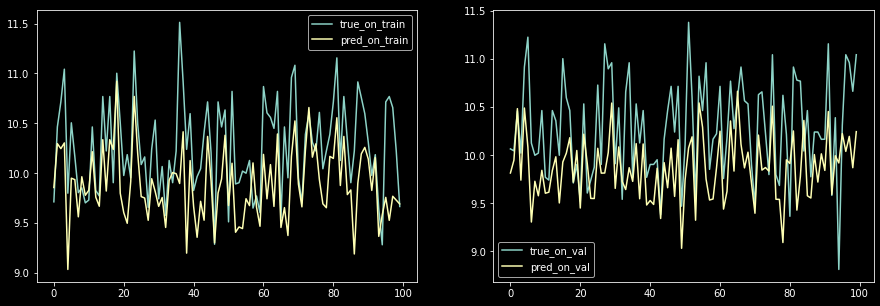

In [70]:
count = 100
plt.figure(figsize = (15, 5))

plt.subplot(1, 2, 1)
plt.plot(range(len(y_true_train[:count])), y_true_train[:count], label = "true_on_train")
plt.plot(range(len(y_pred_train[:count])), y_pred_train[:count], label = "pred_on_train")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(len(y_true_val[:count])), y_true_val[:count], label = "true_on_val")
plt.plot(range(len(y_pred_val[:count])), y_pred_val[:count], label = "pred_on_val")
plt.legend()

### Bonus area 1: three-headed network.

Now you can try to implement the network we've discussed above. Use [__PyTorch nn.Module API__](https://pytorch.org/docs/stable/nn.html#torch.nn.Module).

In [36]:
n_tokens=len(tokens)
n_cat_features=len(categorical_vectorizer.vocabulary_)
hid_size=64

In [37]:
iterator = iterate_minibatches(data_train, 3)
batch, target = next(iterator)
list(batch.keys())

['Title', 'FullDescription', 'Categorical']

In [38]:
title_inp = torch.from_numpy(batch["Title"])
title_inp.shape

torch.Size([3, 13])

In [39]:
head_title = nn.Sequential(
            nn.Embedding(n_tokens, hid_size),
            Reorder(),
            nn.Conv1d(hid_size, 2*hid_size, 2),
            nn.BatchNorm1d(2*hid_size),
            nn.ReLU(),
            nn.Conv1d(2*hid_size, 2*hid_size, 2),
            nn.BatchNorm1d(2*hid_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1),
            nn.Flatten(),
            nn.Linear(2*hid_size, hid_size)
        )

In [40]:
title_out = head_title(title_inp)
title_out.shape

torch.Size([3, 64])

In [41]:
head_desc = nn.Sequential(
            nn.Embedding(n_tokens, hid_size),
            Reorder(),
            nn.Conv1d(hid_size, 2*hid_size, 3),
            nn.BatchNorm1d(2*hid_size),
            nn.ReLU(),
            nn.Conv1d(2*hid_size, 2*hid_size, 3),
            nn.BatchNorm1d(2*hid_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1),
           nn.Flatten(),
            nn.Linear(2*hid_size, hid_size))
desc_inp = torch.from_numpy(batch["FullDescription"])
print(desc_inp.shape)

desc_out = head_desc(desc_inp)
desc_out.shape

torch.Size([3, 779])


torch.Size([3, 64])

In [42]:
batch['Categorical']

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [54]:
n_cat_features

3768

In [71]:
class ThreeInputsNet(nn.Module):
    def __init__(
        self,
        n_tokens=len(tokens),
        n_cat_features=len(categorical_vectorizer.vocabulary_),
        hid_size=64,
    ):
        super().__init__()

        self.title_emb = nn.Embedding(n_tokens, hid_size)
        # YOUR CODE HERE
        # Define modules to process the title.
        self.head_title = nn.Sequential(
            
            nn.Conv1d(hid_size, 2*hid_size, 3),
            nn.BatchNorm1d(2*hid_size),
            nn.ReLU(),
            nn.Conv1d(2*hid_size, 2*hid_size, 3),
            nn.BatchNorm1d(2*hid_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1),
            nn.Flatten(),
            nn.Linear(2*hid_size, hid_size)
        )
        self.desc_emb = nn.Embedding(n_tokens, hid_size)
        # YOUR CODE HERE
        # Define modules to process the description.
        self.head_desc = nn.Sequential(
            
            nn.Conv1d(hid_size, 2*hid_size, 3),
            nn.BatchNorm1d(2*hid_size),
            nn.ReLU(),
            nn.Conv1d(2*hid_size, 2*hid_size, 3),
            nn.BatchNorm1d(2*hid_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1),
            nn.Flatten(),
            nn.Linear(2*hid_size, hid_size)
        )
        # YOUR CODE HERE
        # Define modules to process the categorical features.
        # self.category_out = ...
        self.head_categorical = nn.Linear(n_cat_features, hid_size)
        # YOUR CODE HERE
        # Define fully-connected part which will take outputs of
        # three heads and return the result.
        self.out = nn.Linear(3*hid_size, 1)

    
    def forward(self, whole_input):
        input1, input2, input3 = whole_input
        title_beg = self.title_emb(input1).permute((0, 2, 1))
        # YOUR CODE HERE
        # Process the title.
        title = self.head_title(title_beg)

        full_beg = self.desc_emb(input2).permute((0, 2, 1))
        # YOUR CODE HERE
        # Process the description.
        desc = self.head_desc(full_beg)

        # YOUR CODE HERE
        # Process the categorical features.
        category = self.head_categorical(input3)

        

        concatenated = torch.cat(
            [
                title.view(title.size(0), -1),
                desc.view(desc.size(0), -1),
                category.view(category.size(0), -1),
            ],
            dim=1,
        )

        # YOUR CODE HERE
        # Process the concatenated features to generate network output.
        out = self.out(concatenated)

        return out

In [85]:
train_iterator = iterate_minibatches(data_train, 256)
val_iterator = iterate_minibatches(data_val, 256)
batch, target = next(val_iterator)
batch["Title"].shape

(256, 16)

In [86]:
ex_inp1, ex_inp2, ex_inp3 = batch["Title"], batch["FullDescription"], batch["Categorical"]
ex_inp1, ex_inp2, ex_inp3 = torch.from_numpy(ex_inp1), torch.from_numpy(ex_inp2), torch.from_numpy(ex_inp3)

ex_inp1.shape, ex_inp2.shape, ex_inp3.shape 

(torch.Size([256, 16]), torch.Size([256, 885]), torch.Size([256, 3768]))

In [87]:
model = ThreeInputsNet()
model_out = model((ex_inp1, ex_inp2, ex_inp3))

model_out.shape

torch.Size([256, 1])

In [94]:
criterion = nn.MSELoss()
loss = criterion(model_out.flatten(), torch.from_numpy(target))
loss.backward()


In [66]:
for batch, target in train_iterator:
    print(batch["Title"].shape)
    break

(256, 14)


In [138]:
def train_model(model, data_train, data_val, criterion, 
                optimizer, scheduler, batch_size, num_epochs):
    start_time = time.time()
    
    for epoch in range(num_epochs):
        train_iterator = iterate_minibatches(data_train, batch_size=batch_size, shuffle=True)
        val_iterator = iterate_minibatches(data_val, batch_size=batch_size, shuffle=False)
        start_epoch_time = time.time()
        print(15*"---")
        print(f"epoch: {epoch+1}/{num_epochs}")
        loss_train, loss_val = [], []
        y_true_train, y_true_val = [], []
        y_pred_train, y_pred_val = [], []
        for X_batch, y_batch in train_iterator:
            x_title, x_desc, x_cat = X_batch["Title"], X_batch["FullDescription"], X_batch["Categorical"]
            x_title, x_desc, x_cat = torch.from_numpy(x_title), torch.from_numpy(x_desc), torch.from_numpy(x_cat)
            x_title, x_desc, x_cat = x_title.to(device), x_desc.to(device), x_cat.to(device)
            y_batch = torch.from_numpy(y_batch).to(device)
            output = model((x_title, x_desc, x_cat))
            loss = criterion(output.flatten(), y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            loss_train.append(loss.item())
            y_true_train += list(y_batch.cpu().detach().numpy())
            y_pred_train += list(output.cpu().detach().numpy())
        # scheduler.step()
        
        with torch.no_grad():
            for X_batch, y_batch in val_iterator:
                x_title, x_desc, x_cat = X_batch["Title"], X_batch["FullDescription"], X_batch["Categorical"]
                x_title, x_desc, x_cat = torch.from_numpy(x_title), torch.from_numpy(x_desc), torch.from_numpy(x_cat)
                x_title, x_desc, x_cat = x_title.to(device), x_desc.to(device), x_cat.to(device)
                y_batch = torch.from_numpy(y_batch).to(device)
                output = model((x_title, x_desc, x_cat))
                loss = criterion(output.flatten(), y_batch)
                loss_val.append(loss.item())
                
                y_true_val += list(y_batch.cpu().detach().numpy())
                y_pred_val += list(output.cpu().detach().numpy())
        
        end_epoch_time = time.time()
        
        epoch_time = start_epoch_time - end_epoch_time
        print(f"Time for epoch: {(epoch_time//60):.1f} m, {(epoch_time%60):.2f} s")    
        print(f"Training loss: {np.mean(loss_train):.3f}, r2_score: {r2_score(y_true_train, y_pred_train):.3f} " )
        print(f"Validation loss: {np.mean(loss_val):.3f}, r2_score: {r2_score(y_true_val, y_pred_val):.3f} " )
        print()
    end_time = time.time()
    all_time = start_time - end_time
    print("****" * 15)
    print(f"Trainig time: {(all_time//60):.1f} m, {(all_time%60):1f} s")

In [139]:
model = ThreeInputsNet().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

In [134]:
train_model(model, data_train, data_val, criterion, optimizer, batch_size = 256, num_epochs = 15)

---------------------------------------------
epoch: 1/15
Time for epoch: -2.0 m, 17.45 s
Training loss: 0.532, r2_score: -1.199 
Validation loss: 0.227, r2_score: 0.057 

---------------------------------------------
epoch: 2/15
Time for epoch: -2.0 m, 17.95 s
Training loss: 0.163, r2_score: 0.326 
Validation loss: 0.119, r2_score: 0.504 

---------------------------------------------
epoch: 3/15
Time for epoch: -2.0 m, 17.68 s
Training loss: 0.121, r2_score: 0.499 
Validation loss: 0.132, r2_score: 0.453 

---------------------------------------------
epoch: 4/15
Time for epoch: -2.0 m, 17.41 s
Training loss: 0.113, r2_score: 0.531 
Validation loss: 0.094, r2_score: 0.609 

---------------------------------------------
epoch: 5/15
Time for epoch: -2.0 m, 16.67 s
Training loss: 0.090, r2_score: 0.629 
Validation loss: 0.093, r2_score: 0.615 

---------------------------------------------
epoch: 6/15
Time for epoch: -2.0 m, 16.98 s
Training loss: 0.085, r2_score: 0.650 
Validation loss

In [135]:
@torch.no_grad()
def evaluate_model(model, data, batch_size=256, name=None, **kwargs):
    squared_error = abs_error = num_samples = 0.0
    y_true = []
    y_pred = []
    
    data_iterator = iterate_minibatches(data, batch_size, shuffle=False, **kwargs)
    for batch, target in data_iterator:
        
        x_title, x_desc, x_cat = batch["Title"], batch["FullDescription"], batch["Categorical"]
        x_title, x_desc, x_cat = torch.from_numpy(x_title), torch.from_numpy(x_desc), torch.from_numpy(x_cat)
        x_title, x_desc, x_cat = x_title.to(device), x_desc.to(device), x_cat.to(device)
        
        pred = model((x_title, x_desc, x_cat))[:, 0].cpu().numpy()
        
        y_true += list(target)
        y_pred += list(pred)
        
        squared_error += np.sum(np.square(pred - target))
        abs_error += np.sum(np.abs(pred - target))
        num_samples += len(target)

    if name is not None:
        print(f"{name}:")

    print(f"MSE: {squared_error / num_samples:.5f}")
    print(f"MAE: {abs_error / num_samples:.5f}")
    print(f"R2_score: {r2_score(y_true, y_pred):.5f}")
    
    return y_true, y_pred

y_true_train, y_pred_train = evaluate_model(model, data_train, name="Train")
y_true_val, y_pred_val = evaluate_model(model, data_val, name="Val")

Train:
MSE: 0.04887
MAE: 0.16928
R2_score: 0.79799
Val:
MSE: 0.07745
MAE: 0.21076
R2_score: 0.67793


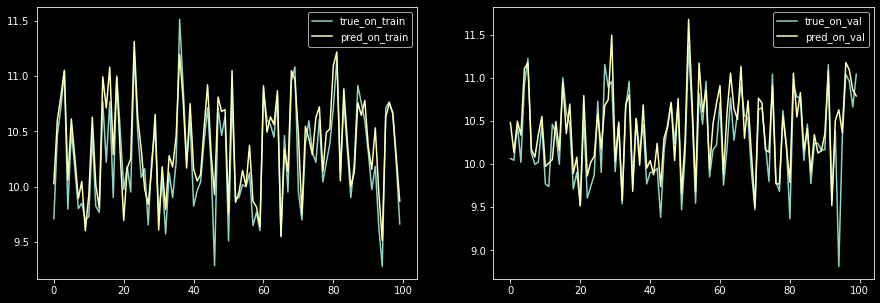

In [136]:
count = 100
plt.figure(figsize = (15, 5))

plt.subplot(1, 2, 1)
plt.plot(range(len(y_true_train[:count])), y_true_train[:count], label = "true_on_train")
plt.plot(range(len(y_pred_train[:count])), y_pred_train[:count], label = "pred_on_train")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(len(y_true_val[:count])), y_true_val[:count], label = "true_on_val")
plt.plot(range(len(y_pred_val[:count])), y_pred_val[:count], label = "pred_on_val")
plt.legend()

### Bonus area 2: comparing RNN to CNN
Try implementing simple RNN (or LSTM) and applying it to this task. Compare the quality/performance of these networks. 
*Hint: try to build networks with ~same number of paremeters.*

In [ ]:
# YOUR CODE HERE

### Bonus area 3: fixing the data leaks
Fix the data leak we ignored in the beginning of the __Deep Learning part__. Compare results with and without data leaks using same architectures and training time.


In [ ]:
# YOUR CODE HERE

__Terrible start-up idea #1962:__ make a tool that automaticaly rephrases your job description (or CV) to meet salary expectations :)